In [2]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

path = os.chdir(os.path.dirname(os.getcwd()))
sys.path.append(path)
sys.path.append('/home/sebastian/Desktop/Git intern/intern/')

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *
del resample
from data.reshape_data import resample


Generate data

<AxesSubplot:>

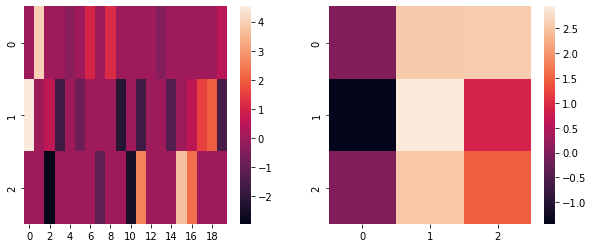

In [3]:
def gen_weights(N_H, N_V, nabla=2, connectivity=0):
    ## initialize parameters
    sparcity = 1 - connectivity

    sp = 1 - 1/N_H
    # initialze fully connected random weight matrix
    W = nabla * torch.randn((N_H, N_V), dtype=torch.float)

    # Make the weight matrix sparse such that only 1 visible is randomly connected to 1 hidden
    for i, idx in enumerate(torch.randperm(N_V)):
        if torch.sum(W[:, idx]==0)/N_H<sp:
            W[:, idx][ np.random.permutation(N_H)[:int(np.ceil(sp * N_H))]] = 0

    # compute the number of zeros we need to have in the weight matrix to obtain the predefined connectivity
    sp = torch.sum(W==0)/W.numel()
    conn = 1 - sp
    n_zeros = int(torch.sum(W==0) - sparcity * W.numel())
    if n_zeros>0:
        # randomly add values to the weight matrix in order to obtain the predefined connectivity
        idx = torch.where(W.ravel() == 0)[0]
        idx = idx[torch.randperm(idx.shape[0])[:n_zeros]]
        W.ravel()[idx] = nabla * torch.randn(n_zeros, dtype=torch.float)
    else:
        print('Minimum connectivity is: '+str(conn))
    # sp = torch.sum(W==0)/W.numel()
    # conn = 1 - sp

    return W
N_H, N_V = 3, 20
W = gen_weights(N_H=N_H, N_V=N_V, nabla=2, connectivity=0.4)
U = gen_weights(N_H=N_H, N_V=N_H, nabla=2, connectivity=0.8)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(W, ax=ax[0])
sns.heatmap(U, ax=ax[1])


In [4]:
def resample(data, sr, mode=1):
    '''
    :param data: original data
    :param sr: sampling rate
    :param mode: =1 take the mean, =2 take instance value
    :return: downsampled data
    '''

    sr = 2
    mode = 1
    N_V, T, n_batches = data.shape
    data1 = np.array(data)

    # make sure that the modulus(T/sr) = 0
    if T % sr != 0:
        data1 = data1[:, :int(np.floor(T / sr)), :]
    s = int(np.floor(T / sr))
    data_nsr = np.zeros([N_V, s, n_batches])

    for batch in range(int(n_batches/20)):
        for t in range(s):
            if mode == 1:
                temp_data = np.mean(data1[:, sr*t:sr*(t + 1), 20*batch:20*(batch+1)], 1)
                temp_data.ravel()[temp_data.ravel() > 0.5] = 1.0
                temp_data.ravel()[temp_data.ravel() < 0.5] = 0.0
                temp_data.ravel()[temp_data.ravel() == 0.5] = 1.0 * (np.random.rand(np.sum(temp_data == 0.5)) > 0.5)
                data_nsr[:, t, 20*batch:20*(batch+1)] = temp_data

            elif mode == 2:
                data_nsr[:, t, 20*batch:20*(batch+1)] = data[:, sr*t, 20*batch:20*(batch+1)]


    return torch.tensor(data_nsr, dtype=torch.float)

In [5]:
sampling_range = [1, 2, 5, 8, 10, 20, 25, 40, 50, 100, 200]
data_nsr2 = resample(data, 2, mode=1)[:, :50, :]
data_nsr5 = resample(data, 5, mode=1)[:, :50, :]
data_nsr8 = resample(data, 8, mode=1)[:, :50, :]
data_nsr10 = resample(data, 10, mode=1)[:, :50, :]
data_nsr20 = resample(data, 20, mode=1)[:, :50, :]
data_nsr25 = resample(data, 25, mode=1)[:, :50, :]
data_nsr40 = resample(data, 40, mode=1)[:, :50, :]
data_nsr50 = resample(data, 50, mode=1)[:, :50, :]

sampling_range_data = [data[:, :50, :], data_nsr2, data_nsr5, data_nsr8, data_nsr10, data_nsr20, data_nsr25, data_nsr40, data_nsr50]

In [10]:
for i in sampling_range_data:
    print(i.shape, torch.mean(i), torch.sum(torch.isnan(i)))

torch.Size([300, 50, 2000]) tensor(0.5024) tensor(0)
torch.Size([300, 50, 2000]) tensor(0.5022) tensor(0)
torch.Size([300, 50, 2000]) tensor(0.5021) tensor(0)
torch.Size([300, 50, 2000]) tensor(0.5021) tensor(0)
torch.Size([300, 50, 2000]) tensor(0.5022) tensor(0)
torch.Size([300, 50, 2000]) tensor(0.5022) tensor(0)
torch.Size([300, 50, 2000]) tensor(0.5022) tensor(0)
torch.Size([300, 50, 2000]) tensor(0.5022) tensor(0)
torch.Size([300, 50, 2000]) tensor(0.5022) tensor(0)


In [9]:
for i, data in enumerate(sampling_range_data):
    torch.save(data, open(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\Sampling rate\delay=2\delay=2_downsampled_'+str(sampling_range[i]),'wb'))

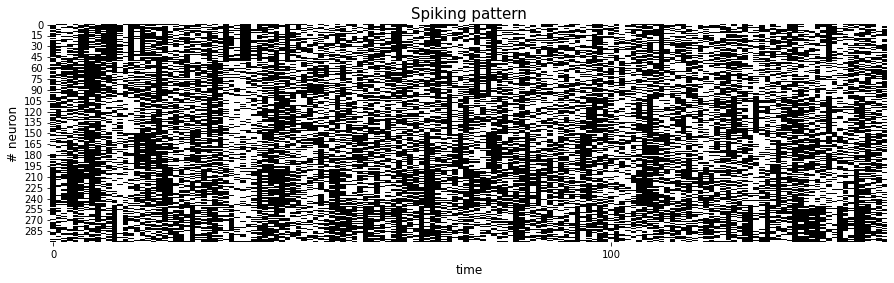

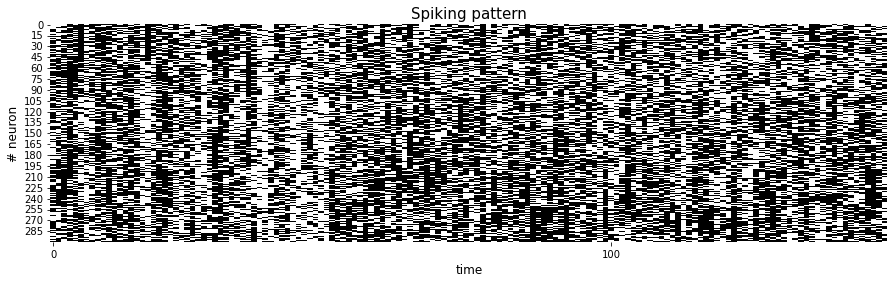

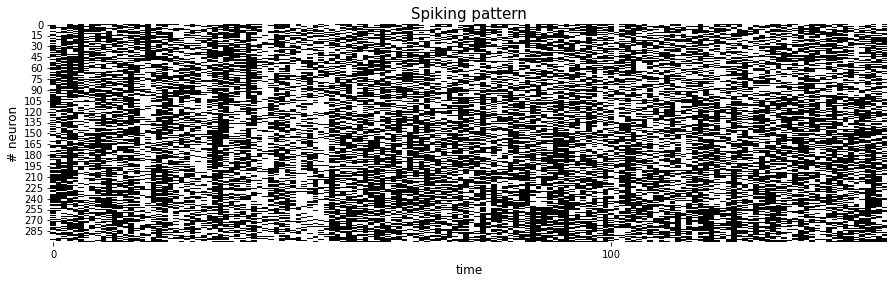

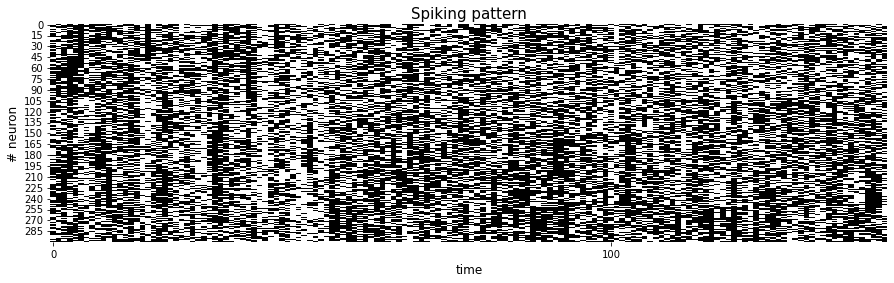

In [7]:
raster_plot(reshape(data[:, :50, :3]))
plt.show()
raster_plot(reshape(data_nsr2[:, :, :3]))
plt.show()
raster_plot(reshape(data_nsr10[:, :, :3]))
plt.show()
raster_plot(reshape(data_nsr50[:, :, :3]))
plt.show()



C:\Users\sebas\anaconda3\envs\RTRBM\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\sebas\anaconda3\envs\RTRBM\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\sebas\anaconda3\envs\RTRBM\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

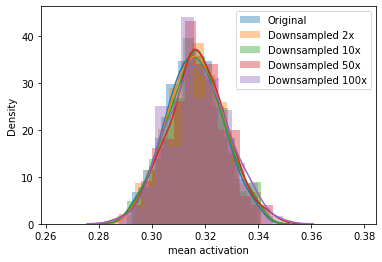

In [6]:
mean_data = torch.mean(data, (1, 2))
mean_data_nsr2 = torch.mean(data_nsr2, (1, 2))
mean_data_nsr10 = torch.mean(data_nsr10, (1, 2))
mean_data_nsr50 = torch.mean(data_nsr50, (1, 2))
mean_data_nsr100 = torch.mean(data_nsr100, (1, 2))

minimum = torch.min(torch.cat([mean_data, mean_data_nsr2, mean_data_nsr10, mean_data_nsr50, mean_data_nsr100]))
maximum = torch.max(torch.cat([mean_data, mean_data_nsr2, mean_data_nsr10, mean_data_nsr50, mean_data_nsr100]))

sns.distplot(mean_data, label='Original')
sns.distplot(mean_data_nsr2, label='Downsampled 2x')
sns.distplot(mean_data_nsr10, label='Downsampled 10x')
sns.distplot(mean_data_nsr50, label='Downsampled 50x')
sns.distplot(mean_data_nsr100, label='Downsampled 100x')

plt.xlabel('mean activation')
plt.legend()
plt.xlim([0.9*minimum, 1.1*maximum])

plt.show()


In [8]:
#torch.save(sampling_range_data, open('/home/sebastian/Desktop/Git intern/intern/data/sampling_range_data', 'wb'))
sampling_range_data = torch.load(open(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\Sampling rate\sampling_range_data', 'rb'))
sampling_range = [1, 2, 5, 8, 10, 20, 25, 40, 50, 100, 200]


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\sebas\\OneDrive\\Intern\\rtrbm_master\\results\\Sampling rate\\sampling_range_data'

In [5]:
i=0
rtrbm_original_data = RTRBM(sampling_range_data[i], N_H=6, device='cuda')
rtrbm_original_data.learn(n_epochs=2000, batchsize=10, lr=1e-3, lr_end=1e-5, start_decay=200)
plt.plot(rtrbm_original_data.errors)
torch.save(rtrbm, open('/home/sebastian/Desktop/Intern/results/Sampling rate/rtrbm_downsampled3001_'+str(int(sampling_range[i])), 'wb'))


NameError: name 'sampling_range_data' is not defined

In [ ]:
for i in range(len(sampling_range_data)):
    rtrbm = RTRBM(sampling_range_data[i], N_H=6, device='cpu', init_biases=True)
    rtrbm.learn(n_epochs=3000, batchsize=10, lr=1e-3, lr_end=1e-6, start_decay = 200, mom=0.9, wc=0.0002)
    torch.save(rtrbm, open('/home/sebastian/Desktop/Intern/results/Sampling rate/rtrbm_downsampled3001_'+str(int(sampling_range[i])), 'wb'))
    plt.plot(rtrbm.errors)
    plt.show()

In [7]:
for i in range(len(sampling_range_data)):
    print('Downsampled by :' +str(sampling_range[i]))
    rtrbm = torch.load(open(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\Sampling rate\rtrbm_downsampled3000_'+str(int(sampling_range[i])), 'rb'), map_location='cpu')
    VH = rtrbm.W.detach().clone()
    HH = rtrbm.W_acc.detach().clone()
    rf = get_hidden_mean_receptive_fields(VH, coordinates, only_max_conn=False)
    create_plot(VH, HH, rf,  coordinates, 0, weight_line_factor=0.1, hiddens_radius=0.1, hidden_weight_thresh=0)

NameError: name 'sampling_range_data' is not defined

In [ ]:
for i in range(len(sampling_range_data)):
    print('Downsampled by :' +str(sampling_range[i]))
    rtrbm = torch.load(open('/home/sebastian/Desktop/Intern/results/Sampling rate/rtrbm_downsampled3000_'+str(int(sampling_range[i])), 'rb'), map_location='cpu')
    plt.plot(rtrbm.errors)
    plt.show()

In [6]:
import numpy as np
from math import cos, sin, atan2
from palettable.tableau import Tableau_10, Tableau_20
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, RegularPolygon
from numpy import radians as rad
import torch


def draw_neuron(x, y, neuron_radius, id=-1):
    # circle = plt.Circle((x, y), radius=neuron_radius, fill=False, color=Tableau_20.mpl_colors[2*id])
    # plt.gca().add_patch(circle)
    # plt.gca().text(x, y-(neuron_radius/4), str(id), size=neuron_radius*1000, ha='center')

    circle = plt.Circle((x, y), radius=neuron_radius, fill=False, color=Tableau_20.mpl_colors[2 * id])
    plt.gca().add_patch(circle)
    plt.gca().text(x + neuron_radius, y + neuron_radius, str(id), ha='center', fontsize=20)


def line_between_two_neurons(neuron1_x, neuron1_y, neuron2_x, neuron2_y, neuron_radius, weight=0.4,
                             weight_line_factor=1):
    angle = atan2(neuron2_x - neuron1_x, neuron2_y - neuron1_y)
    x_adjustment = neuron_radius * sin(angle)
    y_adjustment = neuron_radius * cos(angle)

    # assign colors to lines depending on the sign of the weight
    color = Tableau_10.mpl_colors[3]
    if weight > 0: color = Tableau_10.mpl_colors[2]

    # assign different linewidths to lines depending on the size of the weight
    abs_weight = abs(weight)
    linewidth = 2 * abs_weight * weight_line_factor

    # draw self-connecting arrow
    if neuron1_x == neuron2_x:
        drawCirc(plt.gca(), neuron_radius * 2, neuron1_x, neuron1_y, -30, 230, color_=color, lw=3 * linewidth)

    # draw arrow
    else:
        plt.gca().arrow(neuron1_x + x_adjustment, neuron1_y + y_adjustment,
                        neuron2_x - neuron1_x - 2 * x_adjustment, neuron2_y - neuron1_y - 2 * y_adjustment,
                        lw=3 * linewidth, color=color, length_includes_head=True, head_width=linewidth/20, overhang=0)

def drawCirc(ax, radius, centX, centY, angle_, theta2_, color_='black', lw=1):
    # ========Line
    if lw > 0.1:
        arc = Arc([centX, centY + radius / 2], radius, radius, angle=angle_,
                  theta1=0, theta2=theta2_, capstyle='round', linestyle='-', lw=lw, color=color_)
        ax.add_patch(arc)

        # ========Create the arrow head
        endX = centX + (radius / 2) * np.cos(rad(theta2_ + angle_))  # Do trig to determine end position
        endY = centY + (radius / 2) * np.sin(rad(theta2_ + angle_))

        ax.add_patch(  # Create triangle as arrow head
            RegularPolygon(
                (endX, endY + radius / 2),  # (x,y)
                3,  # number of vertices
                radius / 9,  # radius
                rad(angle_ + theta2_),  # orientation
                color=color_
            )
        )
    # ax.set_xlim([centX-radius,centY+radius]) and ax.set_ylim([centY-radius,centY+radius])
    # Make sure you keep the axes scaled or else arrow will distort


def plot_VH_connections(ax, VH, coordinates, strong_thresh=0.5, markersize=2):
    N_H, N_V = VH.shape
    max_hidden_connection = torch.max(VH, 0)[1]

    for h in range(N_H):
        ax.scatter(coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) > strong_thresh), 0],
                   coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) > strong_thresh), 1],
                   color=Tableau_20.mpl_colors[(2 * h) % 20], s=markersize)

        ax.scatter(coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) < strong_thresh), 0],
                   coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) < strong_thresh), 1],
                   color=Tableau_20.mpl_colors[(2 * h + 1) % 20], s=markersize)


def create_plot(VH, HH, rf, coords, dy, dx=0, markersize_visibles=20, hiddens_radius=0.02, weight_line_factor=1, hidden_weight_thresh=0):
    plt.figure(figsize=(12, 9))
    x_hidden_mean_receptive_fields = rf[:, 0]
    y_hidden_mean_receptive_fields = rf[:, 1]
    N_H = HH.shape[0]

    for h in range(N_H):
        draw_neuron(x_hidden_mean_receptive_fields[h], y_hidden_mean_receptive_fields[h], hiddens_radius, id=h)

    for h in range(N_H):
        for hh in range(N_H):
            if abs(HH[h, hh]) > hidden_weight_thresh:
                if h < hh:
                    dy = -dy
                    dx = -dx
                    line_between_two_neurons(x_hidden_mean_receptive_fields[h]+dx, y_hidden_mean_receptive_fields[h] + dy,
                                             x_hidden_mean_receptive_fields[hh]+dx, y_hidden_mean_receptive_fields[hh] + dy,
                                             hiddens_radius, weight=HH[h, hh], weight_line_factor=weight_line_factor)
                else:
                    dy = abs(dy)
                    dx = abs(dx)
                    line_between_two_neurons(x_hidden_mean_receptive_fields[h]+dx, y_hidden_mean_receptive_fields[h] + dy,
                                             x_hidden_mean_receptive_fields[hh]+dx, y_hidden_mean_receptive_fields[hh] + dy,
                                             hiddens_radius, weight=HH[h, hh], weight_line_factor=weight_line_factor)

    plot_VH_connections(plt.gca(), VH, coords, markersize=markersize_visibles)

    plt.gca().set_xlim(torch.min(coords[:, 0]), torch.max(coords[:, 0]))
    plt.gca().set_ylim(torch.min(coords[:, 1]), torch.max(coords[:, 1]))

    plt.plot(coords[:, 0], coords[:, 1], 'g.', markersize=1, zorder=-10)
    plt.show()

